In [1]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy

class ZScoreGPU():
    
    def __init__(self):

        mod = SourceModule("""
            __global__ void average(float *g_idata, float *average, int limit) { 

                __shared__ float temp[32];  
                unsigned int id = blockIdx.x*blockDim.x + threadIdx.x;
                unsigned int thid=threadIdx.x;
                float aux=0;
                if (id<limit) {
                    aux = g_idata[id];
                }

                aux += __shfl_down_sync(0xffffffff, aux, 1); // Reduction
                aux += __shfl_down_sync(0xffffffff, aux, 2); // Reduction
                aux += __shfl_down_sync(0xffffffff, aux, 4); // Reduction
                aux += __shfl_down_sync(0xffffffff, aux, 8); // Reduction
                aux += __shfl_down_sync(0xffffffff, aux, 16); // Reduction

                if (thid%32==0) {
                    temp[thid/32]=aux;
                }

                unsigned int offset = 1;
                for (int d = 16; d > 0; d >>= 1) { // build sum in place up the tree  
                    __syncthreads();    
                    if (thid < d){ 
                        unsigned int ai = offset*(2*thid+1)-1;   
                        unsigned int bi = offset*(2*thid+2)-1; 
                        temp[bi] += temp[ai]; 
                    }
                offset *= 2; 
            }
            __syncthreads();
            if (thid == 0) atomicAdd(&average[0],(temp[31])/limit);
        }
        __global__ void standardDeviationSquared(float *g_idata, float *average, float* standardDev,unsigned int degreesOfFreedom,unsigned int limit) { 

            __shared__ float temp[32];  
            unsigned int id = blockIdx.x*blockDim.x+threadIdx.x;
            unsigned int thid=threadIdx.x;
            float aux=0;
            if(id<limit) {
                aux=g_idata[id]-average[0];
                aux=(aux*aux)/(degreesOfFreedom);
            }
            aux += __shfl_down_sync(0xffffffff, aux, 1); // Reduction
            aux += __shfl_down_sync(0xffffffff, aux, 2); // Reduction
            aux += __shfl_down_sync(0xffffffff, aux, 4); // Reduction
            aux += __shfl_down_sync(0xffffffff, aux, 8); // Reduction
            aux += __shfl_down_sync(0xffffffff, aux, 16); // Reduction

            if (thid%32==0) {
                temp[thid/32]=aux;
            }

            unsigned int offset = 1;
            for (int d = 16; d > 0; d >>= 1) { // build sum in place up the tree  
                __syncthreads();    
                if (thid < d){ 
                    unsigned int ai = offset*(2*thid+1)-1;   
                    unsigned int bi = offset*(2*thid+2)-1; 
                    temp[bi] += temp[ai]; 
                    }
                offset *= 2; 
            }
            __syncthreads();

            if (thid == 0) atomicAdd(&standardDev[0],temp[31]);
        }    

        __global__ void standarize(float *g_idata, float *average, float standardDev,unsigned int limit) { 

            unsigned int id = blockIdx.x*blockDim.x+threadIdx.x;
            if(id<limit) {
                g_idata[id]=(g_idata[id]-average[0])/standardDev;
            }
        }       

         """)

        self.averageFunc = mod.get_function("average")
        self.standardDeviationSquared = mod.get_function("standardDeviationSquared")
        self.standarize = mod.get_function("standarize")
        
        self.averageFunc.prepare(("P","P","I"))
        self.standardDeviationSquared.prepare(("P","P","P","I","I"))
        self.standarize.prepare(("P","P","f","I"))

            
    def fit(self, x, degreesOfFreedom=None):    

        n=len(x)
        distribution=numpy.float32(x)
        standardDev=numpy.array([0],dtype=numpy.float32)
        distributionZScore=numpy.zeros_like(distribution)

        
        
        distribution_gpu = cuda.mem_alloc(distribution.nbytes)
        standardDev_gpu = cuda.mem_alloc(4)
        average_gpu = cuda.mem_alloc(4)

        
        if degreesOfFreedom is None:
            degreesOfFreedom=n-1
        if n%1024==0:
            blocks=n/1024
        else:
            blocks=(n//1024)+1
        grid=(blocks,1)
        block=(1024,1,1)

        cuda.memcpy_htod(distribution_gpu, distribution)
        cuda.memset_d32(average_gpu,0,1)
        cuda.memset_d32(standardDev_gpu,0,1)

        self.averageFunc.prepared_call(grid,block,distribution_gpu,average_gpu,n)
        self.standardDeviationSquared.prepared_call(grid,block,distribution_gpu,average_gpu,standardDev_gpu,degreesOfFreedom,n)
        
        cuda.memcpy_dtoh(standardDev,standardDev_gpu)
        
        self.standarize.prepared_call(grid,block,distribution_gpu,average_gpu,numpy.sqrt(standardDev[0]),n)

        cuda.memcpy_dtoh(distributionZScore,distribution_gpu)
        
        return distributionZScore;
    



Class to obtain zscore distribution from original distribution

In [4]:
import time

distribution=numpy.random.normal(0.5,0.2,200000000) #Generate sample normal distribution

start = time.time()
zscoreGPU=ZScoreGPU()
zscoreDistribution=zscoreGPU.fit(distribution)

end =time.time()
print("Zscore computation took "+str(end-start)+" seconds")
print(zscoreDistribution)

Zscore computation took 0.38396644592285156 seconds
[ 0.09851848 -0.50827235 -0.31475714 ...  0.5158348   0.65218824
  2.164697  ]


Usage example, with time needed to compute

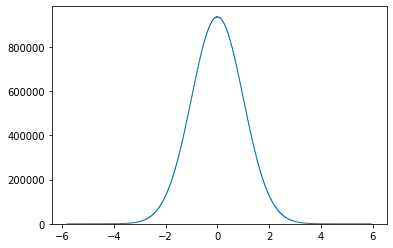

In [5]:
import matplotlib.pyplot as plt

plt.hist(zscoreDistribution,bins=1000,histtype="step")
plt.show()

Plot showing zscore correctness